In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import fitsio

from astropy.table import Table

import sys
#sys.path.insert(0, '/home/aew492/lss-dipoles')
#sys.path.insert(0, '/Users/ksf/code/nyu/research/lss-dipoles')
sys.path.insert(0, '../../lss-dipoles')

#sys.path.insert(0, '../lss-dipoles')
import tools
#from Secrest_dipole import SecrestDipole
from qso_sample import QSOSample

from multipoles import construct_templates, compute_Cells_from_map, compute_Cells
import dipole
#from jackknife import get_longitude_subsamples, compute_jackknife_uncertainty

sys.path.insert(0, '../../gaia-quasars-lss/code')
import selection_function_map as sfm

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# healpix resolution
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

In [15]:
# Quaia

# instantiate a dipole object and load the source density table - NOT corrected by the selection function
# quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
#                     blim=30, maglim=20., save_tag='_r1.0', load_init=True, compcorrect=False,
#                     mask_fn='../../quasar_data_abby/catalogs/masks/mask_master_hpx_r1.0.fits',
#                     basedir='../../quasar_data_abby/catalogs')
#d = SecrestDipole(**quaia_kwargs)
# d = QSOSample(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
#                     blim=30, maglim=20., load_init=True)

quaia_kwargs = dict(initial_catfn='quaia_G20.0.fits', catname='quaia', mag='G',
                    blim=30, maglim=20., save_tag='_r1.0', load_init=True,
                    mask_fn='../../quasar_data_abby/catalogs/masks/mask_master_hpx_r1.0.fits',
                    basedir='../../quasar_data_abby/catalogs')
d =  QSOSample(**quaia_kwargs)
t= d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)
mean, std = np.nanmean(datamap), np.nanstd(datamap)

# and load selection function
#selfunc = d.load_selfunc()

# delete the tables to clear up memory !
del d.initial_cattab
del d.table

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
map_quaia = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

loading initial catalog, quaia_G20.0.fits
755850 sources in initial catalog.


In [30]:
tab_gcat = Table.read('../../gaia-quasars-lss/data/quaia_G20.0.fits')

In [17]:
pixel_indices_gcat = hp.ang2pix(NSIDE, tab_gcat['ra'], tab_gcat['dec'], lonlat=True)
map_gcat = np.bincount(pixel_indices_gcat, minlength=NPIX)

In [18]:
# ecliptic latitudes of each HEALPIXEL
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
# gal_plane_mask = np.zeros_like(datamap)
# gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat

In [19]:
idx_nonzero = map_sel > 0

[ 0.03971989 20.46833413]


Text(0, 0.5, 'quaia number of sources')

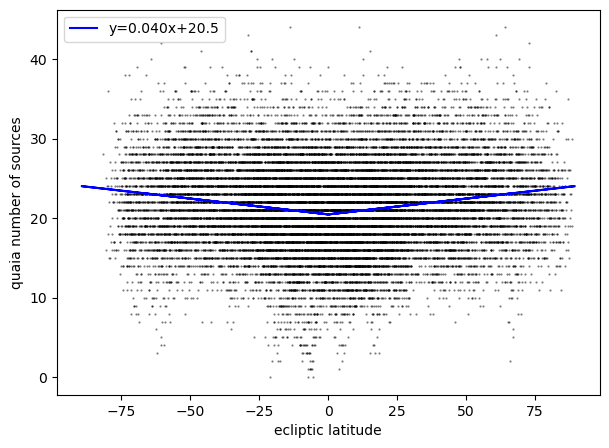

In [20]:
plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia)
p = np.polyfit(np.abs(elat)[idx], map_quaia[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources")

In [31]:
fn_sel = '../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_G20.0.fits'
map_sel = hp.read_map(fn_sel)

[0.00121931 0.60734639]


Text(0, 0.5, 'selection function value')

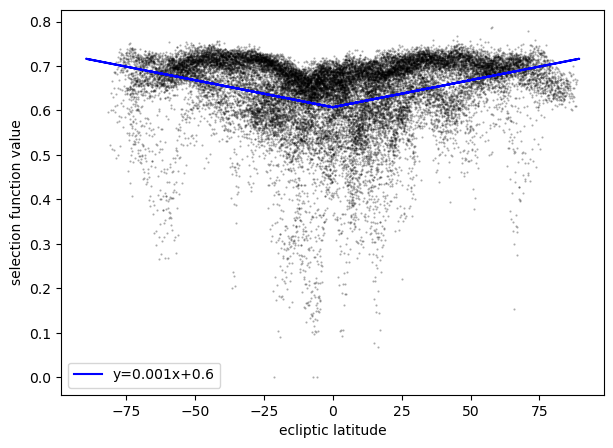

In [32]:
map_sel_masked = np.multiply(map_sel, mask, where=(mask!=0), out=np.full_like(map_sel, np.nan))

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_sel_masked)
p = np.polyfit(np.abs(elat)[idx], map_sel_masked[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_sel_masked[idx], s=0.3, c='k', alpha=0.3)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("selection function value")

[-2.24304711e-03  3.37084130e+01]


/tmp/ipykernel_761626/3396678254.py:1: RuntimeWarning: invalid value encountered in divide
  map_quaia_corr = map_quaia/map_sel


Text(0, 0.5, 'quaia number of sources (selfunc corrected)')

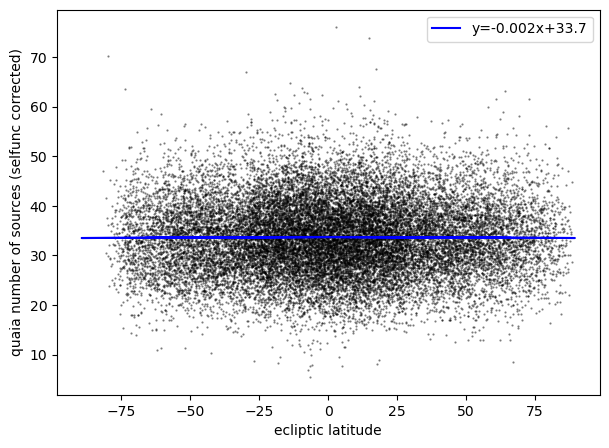

In [33]:
map_quaia_corr = map_quaia/map_sel

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia_corr)
p = np.polyfit(np.abs(elat)[idx], map_quaia_corr[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia_corr[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources (selfunc corrected)")

[-1.69415382e-04  3.36075770e+01]


/tmp/ipykernel_761626/1060897993.py:4: RuntimeWarning: invalid value encountered in divide
  map_quaia_corr = map_quaia/map_sel


Text(0, 0.5, 'quaia number of sources (selfunc corrected)')

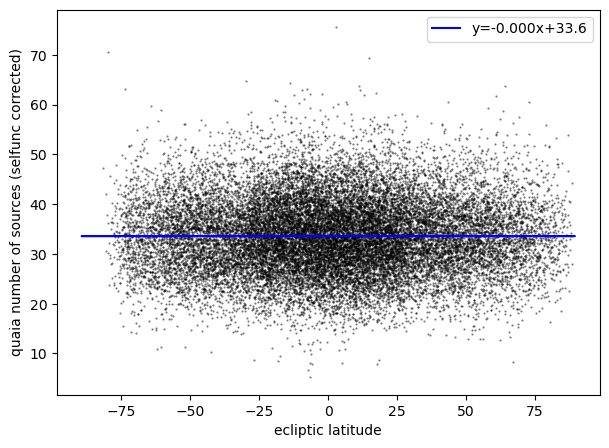

In [29]:
fn_sel = '../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_G20.0_pluszodis.fits'
map_sel = hp.read_map(fn_sel)

map_quaia_corr = map_quaia/map_sel

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia_corr)
p = np.polyfit(np.abs(elat)[idx], map_quaia_corr[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia_corr[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources (selfunc corrected)")

[-1.86621670e-03  3.35313354e+01]


/tmp/ipykernel_761626/3910208247.py:4: RuntimeWarning: invalid value encountered in divide
  map_quaia_corr = map_quaia/map_sel


Text(0, 0.5, 'quaia number of sources (selfunc corrected)')

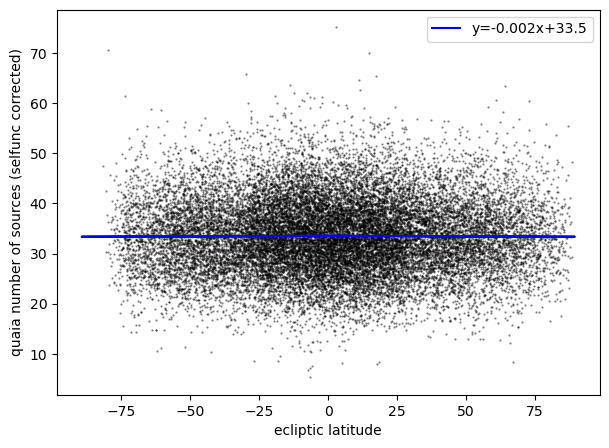

In [34]:
fn_sel = '../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_G20.0_pluszodisnounwise.fits'
map_sel = hp.read_map(fn_sel)

map_quaia_corr = map_quaia/map_sel

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia_corr)
p = np.polyfit(np.abs(elat)[idx], map_quaia_corr[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia_corr[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources (selfunc corrected)")

[-7.41586671e-03  3.37516060e+01]


/tmp/ipykernel_761626/2062973784.py:4: RuntimeWarning: invalid value encountered in divide
  map_quaia_corr = map_quaia/map_sel


Text(0, 0.5, 'quaia number of sources (selfunc corrected)')

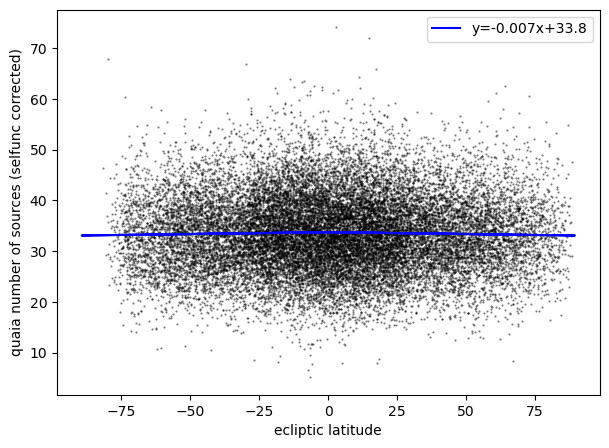

In [35]:
fn_sel = '../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_G20.0_nounwise.fits'
map_sel = hp.read_map(fn_sel)

map_quaia_corr = map_quaia/map_sel

plt.figure(figsize=(7, 5))
ax = plt.gca()
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_quaia_corr)
p = np.polyfit(np.abs(elat)[idx], map_quaia_corr[idx], deg=1)
print(p)

plt.scatter(elat[idx], map_quaia_corr[idx], s=0.3, c='k', alpha=0.5)

ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

plt.legend()
plt.xlabel("ecliptic latitude")
plt.ylabel("quaia number of sources (selfunc corrected)")

### Look at individual templates

In [25]:
f_dict = {'dust': sfm.f_dust,
             'stars': sfm.f_stars,
             'm10': sfm.f_m10,
             'mcs': sfm.f_mcs,
             'unwise': sfm.f_unwise,
             'unwisescan': sfm.f_unwisescan,
             'mcsunwise': sfm.f_mcsunwise,
             }

In [26]:
#template_names = ['dust', 'stars', 'unwise', 'm10', 'unwisescan', 'mcs', 'mcsunwise']
template_names = ['dust', 'stars', 'unwise', 'm10', 'unwisescan']


[-0.00173584  0.1732939 ]
[-4.19542427e-05  2.87372813e+00]
[0.00727969 4.51787203]
[1.96949118e-03 2.09964209e+01]
[0.01343763 4.59564444]


/home/investigator/miniconda3/envs/gaiaenv/lib/python3.12/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')
/home/investigator/code/lss-dipoles/notebooks/../../gaia-quasars-lss/code/selection_function_map.py:273: RuntimeWarning: invalid value encountered in log
  return np.log(map_s)
/home/investigator/code/lss-dipoles/notebooks/../../gaia-quasars-lss/code/selection_function_map.py:288: RuntimeWarning: invalid value encountered in log
  return np.log(map_u)


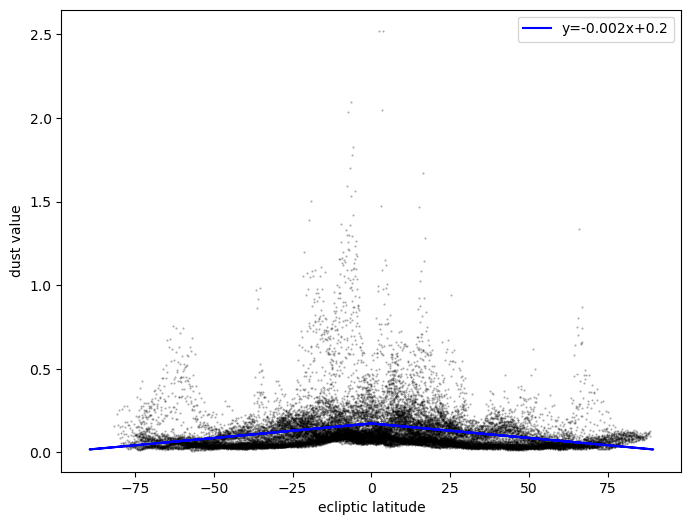

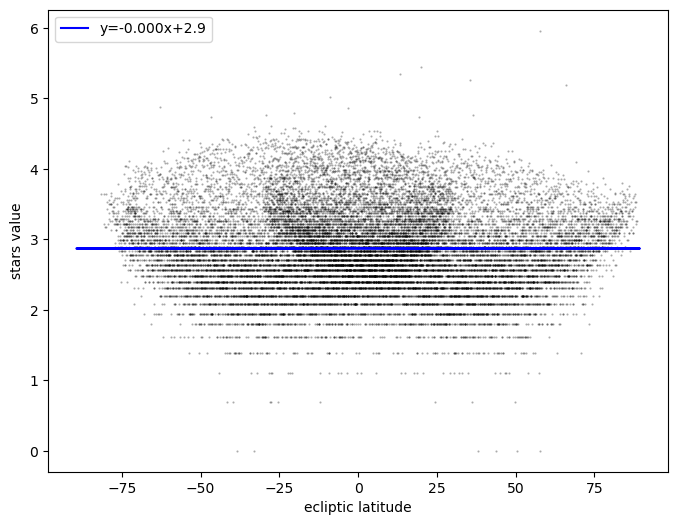

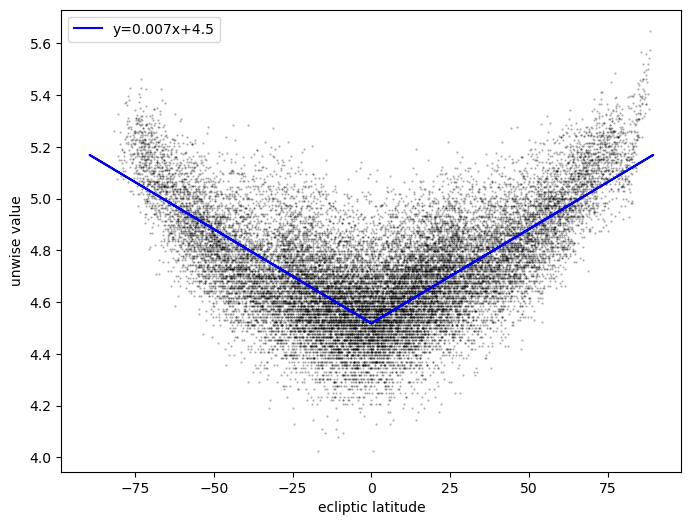

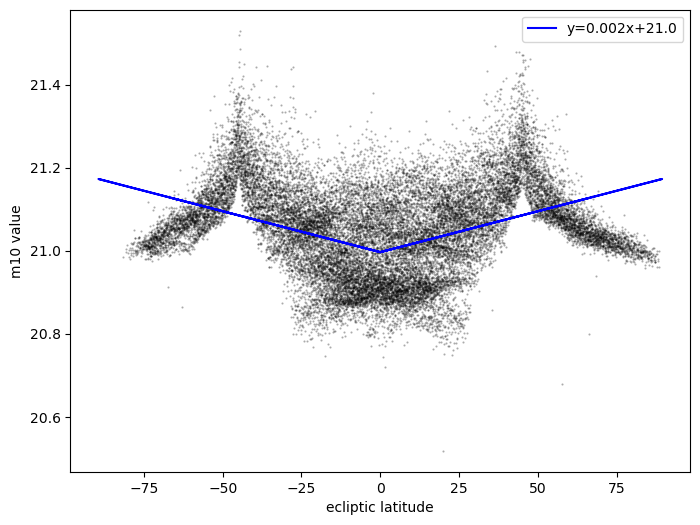

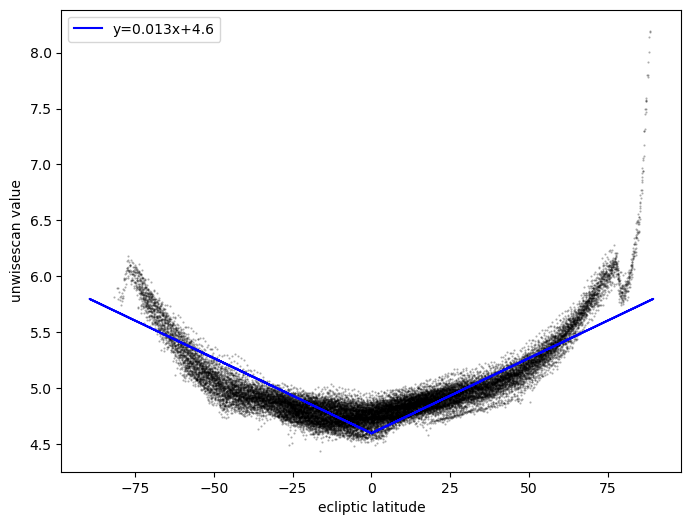

In [27]:
dir_templates = '../../gaia-quasars-lss/data/selection_function_template_maps'

for template_name in template_names:
    
    map_seltemp = np.load(f'{dir_templates}/map_{template_name}_NSIDE{NSIDE}.npy')
    
    map_seltemp_masked = np.multiply(map_seltemp, mask, where=(mask!=0), out=np.full_like(map_seltemp, np.nan))

    # apply same function as in sf fit
    map_seltemp_masked = f_dict[template_name](map_seltemp_masked)

    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    # fit
    idx = ~np.isnan(elat) & ~np.isnan(map_seltemp_masked)
    p = np.polyfit(np.abs(elat)[idx], map_seltemp_masked[idx], deg=1)
    print(p)

    plt.scatter(elat[idx], map_seltemp_masked[idx], s=0.3, c='k', alpha=0.3)

    ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b', label=f'y={p[0]:.3f}x+{p[1]:.1f}')
    # below the plane
    ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

    plt.legend()
    plt.xlabel("ecliptic latitude")
    plt.ylabel(f"{template_name} value")

# CatWISE

In [39]:
# instantiate a dipole object and load the source density table - NOT corrected by the selection function
# catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
#                     blim=30, maglim=16.4, load_init=True,
#                     mask_fn='../../quasar_data_abby/catalogs/masks/mask_master_hpx_r1.0.fits',
#                     basedir='../../quasar_data_abby/catalogs')
# d = SecrestDipole(**catwise_kwargs)

catwise_kwargs = dict(initial_catfn='catwise_agns_master.fits', catname='catwise_agns', mag='w1',
                    blim=30, maglim=16.4, load_init=True,
                    mask_fn='../../quasar_data_abby/catalogs/masks/mask_master_hpx_r1.0.fits',
                    basedir='../../quasar_data_abby/catalogs')
d =  QSOSample(**catwise_kwargs)

d.cut_mag()
t = d.table

# construct map from source density table
datamap = tools.load_catalog_as_map(t, NSIDE=NSIDE)

# mask the galactic plane (mask pixels based on their central sky coordinate)
lon, lat = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)), lonlat=True)
b = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').galactic.b
gal_plane_mask = np.zeros_like(datamap)
gal_plane_mask[np.abs(b.deg) >= d.blim] = 1

# load smaller masks (used in S21): at the pixel level
small_masks = fitsio.read(d.mask_fn)
assert len(small_masks) == len(gal_plane_mask) == hp.nside2npix(NSIDE)

# combine these two into a single mask
mask = gal_plane_mask.astype(bool) & small_masks.astype(bool)

# mask the data: populate a nan map with the data values in unmasked pixels
map_S21 = np.multiply(datamap, mask, where=(mask!=0), out=np.full_like(datamap, np.nan))

loading initial catalog, catwise_agns_master.fits
8532854 sources in initial catalog.
cut w1 > 16.4 -> 3079981 sources left.


In [40]:
# ecliptic latitudes of each HEALPIXEL
elat = SkyCoord(lon * u.deg, lat * u.deg, frame='icrs').geocentrictrueecliptic.lat
# fit
idx = ~np.isnan(elat) & ~np.isnan(map_S21)
p = np.polyfit(np.abs(elat)[idx], map_S21[idx], deg=1)
# correct the densities and fit to the corrected densities
map_S21_elatcorr = map_S21 - np.polyval(p, np.abs(elat.value)) + p[1]

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_elatcorr[idx], deg=1)

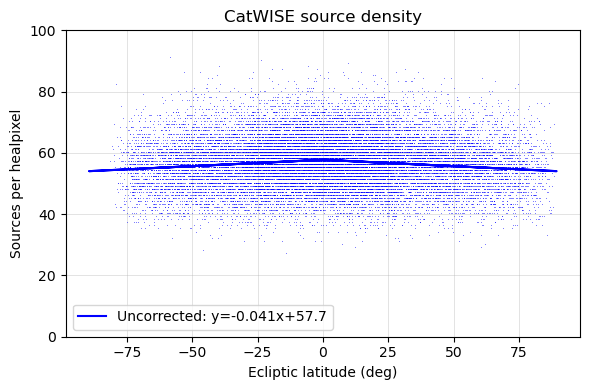

In [41]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
# uncorrected
ax.plot(elat, map_S21, ls='None', marker=',', c='b', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p[0] + p[1], c='b',
        label=f'Uncorrected: y={p[0]:.3f}x+{p[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p[0] + p[1], c='b')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

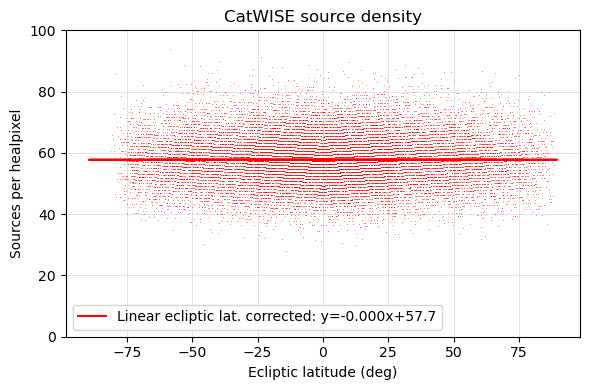

In [42]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

# corrected
ax.plot(elat, map_S21_elatcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Linear ecliptic lat. corrected: y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

In [55]:
# correct the densities and fit to the corrected densities
tag_selfunc = ''
fn_selfunc = f'../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)

map_S21_sfcorr = map_S21/map_selfunc

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_sfcorr[idx], deg=1)

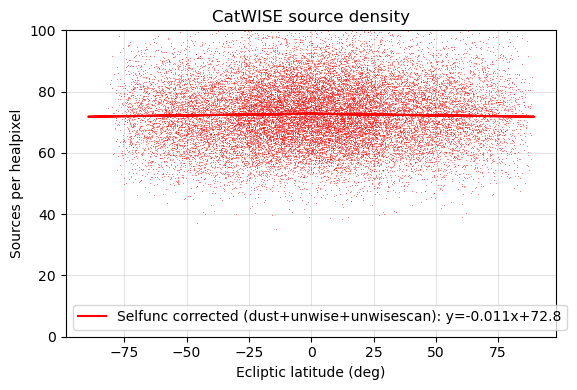

In [56]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

# corrected
ax.plot(elat, map_S21_sfcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Selfunc corrected (dust+unwise+unwisescan): y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

In [48]:
# correct the densities and fit to the corrected densities
tag_selfunc = '_pluszodis'
fn_selfunc = f'../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)

map_S21_sfcorr = map_S21/map_selfunc

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_sfcorr[idx], deg=1)

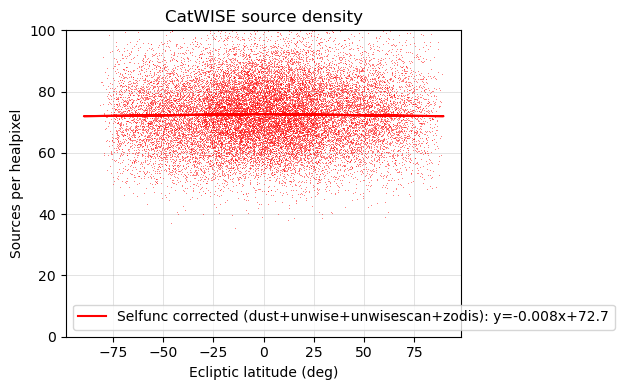

In [49]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

# corrected
ax.plot(elat, map_S21_sfcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Selfunc corrected (dust+unwise+unwisescan+zodis): y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

In [50]:
# correct the densities and fit to the corrected densities
tag_selfunc = '_dustzodis'
fn_selfunc = f'../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)

map_S21_sfcorr = map_S21/map_selfunc

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_sfcorr[idx], deg=1)

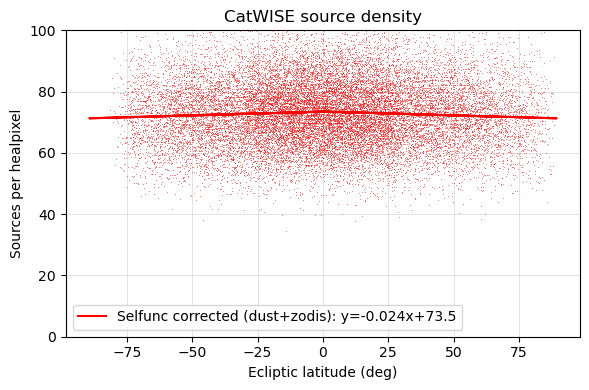

In [51]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

# corrected
ax.plot(elat, map_S21_sfcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Selfunc corrected (dust+zodis): y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()

In [52]:
# correct the densities and fit to the corrected densities
tag_selfunc = '_dust'
fn_selfunc = f'../../gaia-quasars-lss/data/maps/selection_function_NSIDE64_catwise{tag_selfunc}.fits'
#map_zodi = maps.get_unwise_scan_map(NSIDE, fn_map=fn_unwisescanmap)
map_selfunc = hp.read_map(fn_selfunc)

map_S21_sfcorr = map_S21/map_selfunc

p_corr = np.polyfit(np.abs(elat)[idx], map_S21_sfcorr[idx], deg=1)

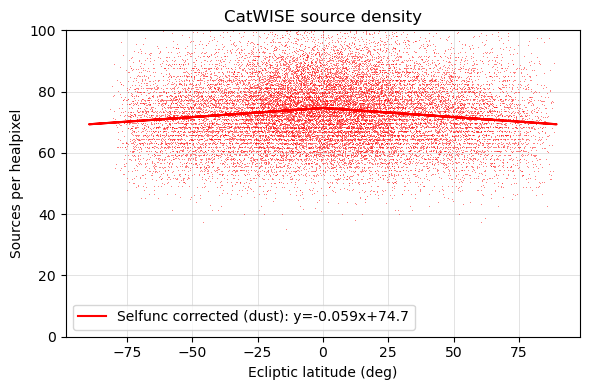

In [53]:
# unbinned : just plot the scatter
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)

# corrected
ax.plot(elat, map_S21_sfcorr, ls='None', marker=',', c='r', alpha=0.5)
# above the plane
ax.plot(elat[elat.value>0], elat.value[elat.value>0] * p_corr[0] + p_corr[1], c='r',
        label=f'Selfunc corrected (dust): y={p_corr[0]:.3f}x+{p_corr[1]:.1f}')
# below the plane
ax.plot(elat[elat.value<0], - elat.value[elat.value<0] * p_corr[0] + p_corr[1], c='r')

ax.grid(alpha=0.5, lw=0.5)
ax.set_ylim(0, 100)
ax.set_xlabel('Ecliptic latitude (deg)')
ax.set_ylabel('Sources per healpixel')
ax.set_title('CatWISE source density')
ax.legend()